#Raw Data
1) Covid-19 Dataset

Summary:

Documentation: https://data.cms.gov/stories/s/COVID-19-Nursing-Home-Data/bkwz-xpvg/

Raw Dataset Download and Data Dictionary: https://data.cms.gov/Special-Programs-Initiatives-COVID-19-Nursing-Home/COVID-19-Nursing-Home-Dataset/s2uc-8wxp

Publish Timeline: New dataset published every month

API Information: https://dev.socrata.com/foundry/data.cms.gov/s2uc-8wxp


2) 2017 Demographic Dataset

Documentation: http://ltcfocus.org/2/faq http://ltcfocus.org/1/about-us

Dataset Download and Data Dictionary: By request.

3) 2019 Provider Dataset

Description: Dataset provides information on Long - Term Care facilities

Centers for Medicare & Medicaid Services (CMS), Provider Information, (2019), https://data.cms.gov/provider-data/dataset/4pq5-n9py

Dataset Download and Data Dictionary:

4) 2019 CMS Inspection Data

Description: Information was provided by client. See below for full listing. 

ProPublica. Nursing Home Inspect, Retrieved 12/3/2020, https://projects.propublica.org/nursing-homes/summary

5) New York Times COVID-19 dataset

Description: A dataset that explains current infection trends within the community of the Long - Term Care facilities. 

The New York Times, (2020), Coronavirus (Covid-19) Data in the United States, Retrieved 11/15/2020, contained data from 6/5/2020 through 11/15/2020 at the time of download, from https://github.com/nytimes/covid-19-data

6) COVID-19 Community social Vulnerability Index

Description: A dataset to examine which communities may be more vulnerable to COVID-19. The website dataset itself is down however we have a saved dataset we are using. 

Surgo Ventures (2020), Bringing Greater Precision to the COVID-19 Response, Retrieved 11/15/2020, https://precisionforcovid.org/

7) Home Health, Hospice, SNF, IRF, and LTCH Provider Table

Description: A dataset similar to the demographic dataset. Used primarily for imputation.

Centers for Medicare & Medicaid Services (CMS), Home Health, Hospice, SNF, IRF and LTCH Provider Table, CY 2017, (2017). https://data.cms.gov/Medicare-Hospice/Home-Health-Hospice-SNF-IRF-and-LTCH-Provider-Tabl/44n3-jbm8

8) Geolocation

Description: A dataset created by using Googles' geolaction API. See within folder. Used for imputation.



#Packages and Setting Drive

In [60]:
import pandas as pd
from pandas import ExcelWriter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno
import math 
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import datetime
from functools import reduce
import re


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#COVID-19 Dataset API

In [ ]:
#please use this API as necessary. Not used for the project. The API imports the column names differently so please proceed with caution

# # API 

# import sys
# !{sys.executable} -m pip install sodapy

# from sodapy import Socrata

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.cms.gov", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.cms.gov,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("s2uc-8wxp", limit = 2000000)

# # Convert to pandas DataFrame
# COVID = pd.DataFrame.from_records(results)

#Raw Data Upload

In [62]:
# provider level
provider_info = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/Provider_Info.csv")  

# weekly, provider level
COVID = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/COVID-19_Nursing_Home_Dataset.csv")

# replacement for hospice
demographic_2017 = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/facility_2017 - demographic data complete.csv")

# hospice data for imputation 
hospice = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/Home_Health__Hospice__SNF__IRF_and_LTCH_Provider_Table__CY_2019EST.csv")

dependent_variable = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/june_aug_dataframe_without_outliers.csv") 


#clean inspection data
inspection = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/unstructured.csv") 

# ny times
ny = pd.read_csv('/content/drive/MyDrive/CapstoneProject/Final_folder/Skeleton/Raw_Data/us-counties_level_covid.csv')

#missing geolocation
filledaddress = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/filledaddress.csv") 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,82,83) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Filling in missing geolocation

In [63]:
#formatting Federal Provider # and Provider Address

COVID['Federal Provider Number'] = COVID['Federal Provider Number'].map(str)
COVID['Provider Address'] = COVID['Provider Address'].str.strip()
COVID['Provider Address'] = COVID['Provider Address'].replace('\s+', ' ', regex = True)

#creating a new column to merge on
COVID['Full_Address'] = COVID['Provider Address'].map(str) + ',' + COVID['Provider City'].map(str) + ',' + COVID['Provider State'].map(str) + ',' + COVID['Provider Zip Code'].map(str)

#renaming column to match COVID-19
filledaddress.rename(columns = {"input_string": "Full_Address"}, inplace=True)

#Removing unnecessary column
filledaddress.drop('Unnamed: 0', inplace = True, axis = 1)

#Removing Duplicates
filledaddress.drop_duplicates(subset=['Full_Address'], inplace= True)

 #formatting to match COVID-19 dataset
filledaddress['geoinput'] = 'POINT (' + filledaddress['longitude'].map(str) + ' ' + filledaddress['latitude'].map(str) + ')'

#Merging 2 datasets to fix missing geolocation
COVID = COVID.merge(filledaddress, on= 'Full_Address', how = 'left', indicator=True)
COVID['Geolocation'].fillna(COVID['geoinput'], inplace=True)

#Demographic Data

##Imputation

In [64]:
# Federal Provider Number column name change
demographic_2017 = demographic_2017.rename(columns={'PROV1680': 'Federal Provider Number'})

In [65]:
#Removing LNE and replacing with NANs for imputation
demographic_2017 = demographic_2017.replace('LNE',np.nan)

In [66]:
#Checking column names
demographic_2017.columns

Index(['year', 'accpt_id', 'Federal Provider Number', 'PROV0475', 'PROV2720',
       'PROV3225', 'PROV2905', 'state', 'county', 'totbeds', 'alzunit',
       'anyunit', 'paymcaid', 'paymcare', 'multifac', 'profit', 'hospbase',
       'restrain', 'acuindex2', 'anymdex', 'rn2nrs', 'dchrppd', 'rnhrppd',
       'lpnhrppd', 'cnahrppd', 'nhlong', 'nhlat', 'occpct', 'agg_cmi_2011p',
       'agglocare_2011p', 'agg_hosp', 'agg_comm', 'aggadl_2011p', 'agglowcfs',
       'aggmidcfs', 'agghighcfs', 'agg_female', 'aggblack_2011p',
       'agghisp_2011p', 'aggwhite_2011p', 'agg_u65', 'adm_bed', 'avgage',
       'avgadl_2011p', 'avgrugcmi_2011p', 'pctlocare_2011p', 'pctfem',
       'pctblack_2011p', 'pcthisp_2011p', 'pctwhite_2011p', 'pctunder65',
       'pctlowcfs', 'pctmidcfs', 'pcthighcfs', 'pctbedft_2011p', 'pctwalking',
       'pctincont_bladr_2011p', 'pctincont_bowel_2011p', 'pctcath_2011p',
       'pctchf', 'pcthyper', 'pctschiz_bipol', 'pctvent_2011p', 'pctuti',
       'pctfall30_2011p', 'pcto

In [67]:
#Removing nation and state level summary
hospice = hospice[hospice['Summary Category']!="NATION"]
hospice = hospice[hospice['Summary Category']!="STATE"]

In [68]:
#Defining variables
hospice_white = hospice[['Provider ID','Percent White Beneficiaries']]
hospice_white = hospice_white[hospice_white['Percent White Beneficiaries']!="*"]
hospice_black = hospice[['Provider ID','Percent Black Beneficiaries']]
hospice_black = hospice_black[hospice_black['Percent Black Beneficiaries']!="*"]
hospice_hisp = hospice[['Provider ID','Percent Hispanic Beneficiaries']]
hospice_hisp = hospice_hisp[hospice_hisp['Percent Hispanic Beneficiaries']!="*"]

###Imputation for Age

In [69]:
#Remove NaN
No_LNE_avgage = demographic_2017[demographic_2017['avgage'].notnull()]

#Compute county median
temp = No_LNE_avgage.astype({'county': 'category', "avgage":"float"}).groupby(['state','county'])
county_avgage = temp.agg({"avgage": "median"})
county_avgage =county_avgage.rename(columns={'avgage': 'median avgage'})

#Compute state median
temp = No_LNE_avgage.astype({ "avgage":"float"}).groupby(['state'])
state_avgage = temp.agg({"avgage": "median"})
state_avgage =state_avgage.rename(columns={'avgage': 'state median avgage'})

#Replace null with county median
demographic_2017 = demographic_2017.merge(county_avgage, left_on=['state','county'], right_on = ['state','county'], how="left")
demographic_2017['avgage'] = demographic_2017.astype({ "avgage":"float"}).apply(lambda x: x['median avgage'] if math.isnan(x['avgage']) else x['avgage'], axis=1)

#Replace null with state median
demographic_2017 = demographic_2017.merge(state_avgage, left_on=['state'], right_on = ['state'], how="left")
demographic_2017['avgage'] = demographic_2017.astype({ "avgage":"float"}).apply(lambda x: x['state median avgage'] if math.isnan(x['avgage'])  else x['avgage'], axis=1)

demographic_2017['avgage'].astype({ "avgage":"float"}).sort_values()

del demographic_2017['state median avgage']
del demographic_2017['median avgage']

###Imputation for Percent Female

In [70]:
#Remove NaN
No_female = demographic_2017[demographic_2017['pctfem'].notnull()]

#Need to figure out what this means
No_female = No_female[No_female["pctfem"]!="."]

#Compute county median
temp = No_female.astype({'county': 'category', "pctfem":"float"}).groupby(['state','county'])
female_county = temp.agg({"pctfem": "median"})
female_county =female_county.rename(columns={'pctfem': 'median pctfem'})

#Compute state median
temp = No_female.astype({"pctfem":"float"}).groupby(['state'])
state_female = temp.agg({"pctfem": "median"})
state_female =state_female.rename(columns={'pctfem': 'state median pctfem'})

#Replace null with county median
demographic_2017  = demographic_2017.merge(female_county, left_on=['state','county'], right_on = ['state','county'], how="left")
demographic_2017['pctfem'] = demographic_2017.astype({ "pctfem":"float"}).apply(lambda x: x['median pctfem'] if math.isnan(x['pctfem'])  else x['pctfem'], axis=1)

#Replace null with state median
demographic_2017  = demographic_2017.merge(state_female, left_on=['state'], right_on = ['state'], how="left")
demographic_2017['pctfem'] = demographic_2017.astype({ "pctfem":"float"}).apply(lambda x: x['state median pctfem'] if math.isnan(x['pctfem']) else x['pctfem'], axis=1)

del demographic_2017['state median pctfem']
del demographic_2017['median pctfem']
demographic_2017['pctfem'].astype({ "pctfem":"float"}).sort_values()

4145       0.0
6349       0.0
6863       0.0
7056       0.0
8274       0.0
         ...  
7129     100.0
7980     100.0
6015     100.0
10278    100.0
13564    100.0
Name: pctfem, Length: 14956, dtype: float64

###Imputation for Percent Black

In [71]:
#combining hospice with demographic dataset

hospice_black['Percent Black Beneficiaries'] = hospice_black.apply(lambda x: float(x['Percent Black Beneficiaries'].strip('%')) , axis=1) 
demographic_2017  = demographic_2017.merge(hospice_black, left_on='Federal Provider Number', right_on = ['Provider ID'], how="left")
demographic_2017['pctblack_2011p'] = demographic_2017.astype({ "pctblack_2011p":"float"}).apply(lambda x: x['Percent Black Beneficiaries'] if  math.isnan(x['pctblack_2011p']) 
                                                                                                else x['pctblack_2011p'], axis=1) 
del demographic_2017['Percent Black Beneficiaries']

In [72]:
#Completing imputation

demographic_2017['pctblack_2011p'] =demographic_2017.apply(lambda x: 1100/x['totbeds'] if math.isnan(x['pctblack_2011p']) and x['totbeds']>=129
                                                          else (600/x['totbeds'] if math.isnan(x['pctblack_2011p']) and x['totbeds']>=67 
                                                                else(100/x['totbeds'] if math.isnan(x['pctblack_2011p']) else x['pctblack_2011p'] )) , axis=1)
demographic_2017['pctblack_2011p'] = demographic_2017.astype({ "pctblack_2011p":"float"}).apply(lambda x: 100 if x['pctblack_2011p']>100 else x['pctblack_2011p'], axis=1)
demographic_2017['pctblack_2011p'].astype({ "pctblack_2011p":"float"}).sort_values()

7477       0.00
7905       0.00
7907       0.00
7908       0.00
7911       0.00
          ...  
5221      98.15
10211     98.51
6341      98.77
8831      99.43
12216    100.00
Name: pctblack_2011p, Length: 14956, dtype: float64

In [ ]:
# This is another version of imputation. Feel free to use as necessary. 
#Remove NaN
# No_LNE_black = demographic_2017[demographic_2017['pctblack_2011p'].notnull()]
# temp = No_LNE_black.astype({'County': 'category', "pctblack_2011p":"float"}).groupby(['Provider State_x','County'])

# # .agg({"duration": "sum"})
# county_black= temp.agg({"pctblack_2011p": "median"})
# county_black =county_black.rename(columns={'pctblack_2011p': 'median pctblack_2011p'})

# demographic_2017  = demographic_2017.merge(county_black, left_on=['Provider State_x','County'], right_on = ['Provider State_x','County'], how="left")

# # 
# demographic_2017['pctblack_2011p'] = demographic_2017.astype({'County': 'category', "pctblack_2011p":"float"}).apply(lambda x: x['median pctblack_2011p'] if  math.isnan(x['pctblack_2011p'])  else x['pctblack_2011p'], axis=1)




# temp = No_LNE_black.astype({'County': 'category', "pctblack_2011p":"float"}).groupby(['Provider State_x'])

# # .agg({"duration": "sum"})
# state_black= temp.agg({"pctblack_2011p": "median"})
# state_black =state_black.rename(columns={'pctblack_2011p': 'state median pctblack_2011p'})

# demographic_2017  = demographic_2017.merge(state_black, left_on="Provider State_x", right_on = "Provider State_x", how="left")


# demographic_2017['pctblack_2011p'] = demographic_2017.astype({ "pctblack_2011p":"float"}).apply(lambda x: x['state median pctblack_2011p'] if  math.isnan(x['pctblack_2011p'])  else x['pctblack_2011p'], axis=1) 
# del demographic_2017['state median pctblack_2011p']
# del demographic_2017['median pctblack_2011p']
# demographic_2017['pctblack_2011p'].astype({ "pctblack_2011p":"float"}).sort_values()

###Imputation for Percent White

In [73]:
#combining hospice with demographic dataset

hospice_white['Percent White Beneficiaries'] = hospice_white.apply(lambda x: float(x['Percent White Beneficiaries'].strip('%')) , axis=1) 
demographic_2017  = demographic_2017.merge(hospice_white, left_on='Federal Provider Number', right_on = ['Provider ID'], how="left")
demographic_2017['pctwhite_2011p'] = demographic_2017.astype({ "pctwhite_2011p":"float"}).apply(lambda x: x['Percent White Beneficiaries'] if  math.isnan(x['pctwhite_2011p']) 
                                                                                                else x['pctwhite_2011p'], axis=1) 
del demographic_2017['Percent White Beneficiaries']

In [74]:
#Completing imputation

demographic_2017['pctwhite_2011p'] =demographic_2017.apply(lambda x: 1100/x['totbeds'] if math.isnan(x['pctwhite_2011p']) and x['totbeds']>=129
                                                          else (600/x['totbeds'] if math.isnan(x['pctwhite_2011p']) and x['totbeds']>=67 
                                                                else(100/x['totbeds'] if math.isnan(x['pctwhite_2011p']) else x['pctwhite_2011p'] )) , axis=1)
demographic_2017['pctwhite_2011p'] = demographic_2017.astype({ "pctwhite_2011p":"float"}).apply(lambda x: 100 if x['pctwhite_2011p']>100 else x['pctwhite_2011p'], axis=1)
demographic_2017['pctwhite_2011p'].astype({ "pctwhite_2011p":"float"}).sort_values()

2143       0.0
2449       0.0
1071       0.0
654        0.0
6856       0.0
         ...  
5043     100.0
10737    100.0
5046     100.0
5035     100.0
7477     100.0
Name: pctwhite_2011p, Length: 14956, dtype: float64

###Imputation for Percent Hispanic

In [75]:
##combining hospice with demographic dataset

hospice_hisp['Percent Hispanic Beneficiaries'] = hospice_hisp.apply(lambda x: float(x['Percent Hispanic Beneficiaries'].strip('%')) , axis=1) 
demographic_2017  = demographic_2017.merge(hospice_hisp, left_on='Federal Provider Number', right_on = ['Provider ID'], how="left")
demographic_2017['pcthisp_2011p'] = demographic_2017.astype({ "pcthisp_2011p":"float"}).apply(lambda x: x['Percent Hispanic Beneficiaries'] if  math.isnan(x['pcthisp_2011p']) 
                                                                                                else x['pcthisp_2011p'], axis=1) 
del demographic_2017['Percent Hispanic Beneficiaries']

In [76]:
#completing imputation

demographic_2017['pcthisp_2011p'] =demographic_2017.apply(lambda x: 1100/x['totbeds'] if math.isnan(x['pcthisp_2011p']) and x['totbeds']>=129
                                                          else (600/x['totbeds'] if math.isnan(x['pcthisp_2011p']) and x['totbeds']>=67 
                                                                else(100/x['totbeds'] if math.isnan(x['pcthisp_2011p']) else x['pcthisp_2011p'] )) , axis=1)
demographic_2017['pcthisp_2011p'] = demographic_2017.astype({ "pcthisp_2011p":"float"}).apply(lambda x: 100 if x['pcthisp_2011p']>100 else x['pcthisp_2011p'], axis=1)
demographic_2017['pcthisp_2011p'].astype({ "pcthisp_2011p":"float"}).sort_values()

0          0.00
7830       0.00
7831       0.00
7832       0.00
7833       0.00
          ...  
2506      97.88
14939     98.13
2449     100.00
2143     100.00
12835    100.00
Name: pcthisp_2011p, Length: 14956, dtype: float64

In [ ]:
# This is another imputation measure for percent hispanic. Feel free to use as necessary.  
#Remove NaN
# No_LNE_hisp = demographic_2017[demographic_2017['pcthisp_2011p'].notnull()]
# temp = No_LNE_hisp.astype({'county': 'category', "pcthisp_2011p":"float"}).groupby(['state','county'])

# # .agg({"duration": "sum"})
# county_black= temp.agg({"pcthisp_2011p": "median"})
# county_black =county_black.rename(columns={'pcthisp_2011p': 'median pcthisp_2011p'})

# demographic_2017  = demographic_2017.merge(county_black, left_on=['state','county'], right_on = ['state','county'], how="left")

# # 
# demographic_2017['pcthisp_2011p'] = demographic_2017.astype({'county': 'category', "pcthisp_2011p":"float"}).apply(lambda x: x['median pcthisp_2011p'] if  math.isnan(x['pcthisp_2011p'])  else x['pcthisp_2011p'], axis=1)




# temp = No_LNE_hisp.astype({'County': 'category', "pcthisp_2011p":"float"}).groupby(['Provider State_x'])

# # .agg({"duration": "sum"})
# state_black= temp.agg({"pcthisp_2011p": "median"})
# state_black =state_black.rename(columns={'pcthisp_2011p': 'state median pcthisp_2011p'})

# demographic_2017  = demographic_2017.merge(state_black, left_on="Provider State_x", right_on = "Provider State_x", how="left")


# demographic_2017['pctblack_2011p'] = demographic_2017.astype({ "pcthisp_2011p":"float"}).apply(lambda x: x['state median pcthisp_2011p'] if  math.isnan(x['pcthisp_2011p'])  else x['pcthisp_2011p'], axis=1) 
# del demographic_2017['state median pcthisp_2011p']
# del demographic_2017['median pcthisp_2011p']
# demographic_2017['pcthisp_2011p'].astype({ "pcthisp_2011p":"float"}).sort_values()

###Imputation of hypertension



In [77]:
#Completing Imputation

demographic_2017['pcthyper'] =demographic_2017.apply(lambda x: 1100/x['totbeds'] if (x['pcthyper']== "LNE" or x['pcthyper']== ".") and x['totbeds']>=129
                                                          else (600/x['totbeds'] if (x['pcthyper']== "LNE" or x['pcthyper']== ".") and x['totbeds']>=67 
                                                                else(100/x['totbeds'] if (x['pcthyper']== "LNE" or x['pcthyper']== ".") else x['pcthyper'] )) , axis=1)


In [78]:
#Replacing missing values with values from imputation

demographic_2017['pcthyper'] = demographic_2017['pcthyper'].fillna(demographic_2017['pcthyper'].apply(float).mean())

#Provider Data

##Imputation

In [79]:
from sklearn.impute import KNNImputer

In [80]:
  #Selecting Imputed columns
  imputed_columns= ['Average Number of Residents Per Day','Overall Rating','Health Inspection Rating','QM Rating','Long-Stay QM Rating','Short-Stay QM Rating','Staffing Rating','RN Staffing Rating', 'Reported Nurse Aide Staffing Hours per Resident per Day',
  'Reported LPN Staffing Hours per Resident per Day','Reported RN Staffing Hours per Resident per Day','Reported Licensed Staffing Hours per Resident per Day',
  'Reported Total Nurse Staffing Hours per Resident per Day','Reported Physical Therapist Staffing Hours per Resident Per Day','Case-Mix Nurse Aide Staffing Hours per Resident per Day',
  'Case-Mix LPN Staffing Hours per Resident per Day','Case-Mix RN Staffing Hours per Resident per Day','Case-Mix Total Nurse Staffing Hours per Resident per Day','Adjusted Nurse Aide Staffing Hours per Resident per Day',
  'Adjusted LPN Staffing Hours per Resident per Day','Adjusted RN Staffing Hours per Resident per Day','Adjusted Total Nurse Staffing Hours per Resident per Day','Total Weighted Health Survey Score']

In [81]:
#Using KNN as an imputation method
imputer = KNNImputer(n_neighbors=5)
imputer.fit(provider_info[imputed_columns])

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [82]:
#Completing KNN imputation

new = pd.DataFrame(imputer.transform(provider_info[imputed_columns]), columns =imputed_columns)
for col in imputed_columns:
    provider_info[col] = new[col]
# row order should not change

In [83]:
#Understanding true missing information

for col,missing in zip(provider_info.columns,provider_info.isnull().sum()):
    if missing > 0 and "Footnote" not in col:
        print(col + ":  "+ str(missing))

Special Focus Status:  14849
Most Recent Health Inspection More Than 2 Years Ago:  25
Rating Cycle 1 Standard Survey Health Date:  25
Rating Cycle 2 Standard Health Survey Date:  118
Rating Cycle 3 Standard Health Survey Date:  234
Location:  1134


In [84]:
#Understanding number of nulls for SFF status. 

print(provider_info['Special Focus Status'].isnull().sum())
provider_info['Special Focus Status'] = provider_info['Special Focus Status'].astype('string')
provider_info['Special Focus Status'].sort_values()

14849


8993      SFF
10596     SFF
2914      SFF
6918      SFF
6974      SFF
         ... 
15372    <NA>
15373    <NA>
15374    <NA>
15375    <NA>
15376    <NA>
Name: Special Focus Status, Length: 15377, dtype: string

In [85]:
#replacing NAs with Not SFF

provider_info['Special Focus Status'].fillna('not SFF', inplace =True)
provider_info['Special Focus Status'] = provider_info['Special Focus Status'].astype("category")
provider_info['Special Focus Status'].sort_values()

8789         SFF
6918         SFF
2790         SFF
2783         SFF
9858         SFF
          ...   
5220     not SFF
5221     not SFF
5222     not SFF
5210     not SFF
15376    not SFF
Name: Special Focus Status, Length: 15377, dtype: category
Categories (3, object): ['SFF', 'SFF Candidate', 'not SFF']

#COVID-19 Nursing Home Data

##Filtering COVID-19 Nursing Home Data

1) Submitted Data Check = Y

2) Passed Quality Assurance Check = Y

Explanation: We only want to work with data that has passed the quality assurance check from CMS. So we are limiting our dataset to only those that pass. 

In [86]:
#Replaced Ys and Ns with 1s and 0s for easier coding. 

COVID.replace({'Y':1,'N':0},inplace = True)

In [87]:
#Filtering by Quality Assurance Check
submited =COVID[COVID["Submitted Data"] == 1]
Covid_filtered = submited[submited['Passed Quality Assurance Check'] == 1]

In [88]:
#Updating types for 2 columns
Covid_filtered['Week Ending'] = pd.to_datetime(Covid_filtered['Week Ending'])

Covid_filtered['Federal Provider Number'] = Covid_filtered['Federal Provider Number'].astype('category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Feature Engineering

### Split 5.24 as New Feature Input



In [89]:
df_5_24 = Covid_filtered[Covid_filtered['Week Ending'] == datetime.datetime(2020,5,24)][['Federal Provider Number','Residents Total Admissions COVID-19','Residents Total Confirmed COVID-19','Residents Total Suspected COVID-19','Residents Total All Deaths','Residents Total COVID-19 Deaths','Total Number of Occupied Beds','Staff Total Confirmed COVID-19','Staff Total Suspected COVID-19','Staff Total COVID-19 Deaths']]
df_5_24.columns = ['Federal Provider Number']+['May_24_'+i for i in df_5_24.columns if i !='Federal Provider Number']

In [90]:
Covid_filtered = Covid_filtered[Covid_filtered['Week Ending'] != datetime.datetime(2020,5,24)]

### Suspected but not Tested for resident




In [91]:
Covid_filtered['suspected_but_no_test_resident'] = 0
Covid_filtered.loc[(Covid_filtered['Residents Weekly Suspected COVID-19'] >0) &( Covid_filtered['Tested Residents with New Signs or Symptoms'] == 0),'suspected_but_no_test_resident'] = 1

### Suspected but not Tested for Staff

In [92]:
Covid_filtered['suspected_but_no_test_staff'] = 0
Covid_filtered.loc[(Covid_filtered['Staff Weekly Suspected COVID-19'] >0)&( Covid_filtered['Tested Staff and/or Personnel with New Signs or Symptoms'] == 0), 'suspected_but_no_test_resident'] = 1    

## Create Dependent Variables


Dependent Variable Construction for non-sliding windown version. Not used for final model but still could provide valuable information

In [104]:
#select relevant columns
dependent_variable = Covid_filtered[['Week Ending','Federal Provider Number','Total Number of Occupied Beds',
                              'Residents Weekly Confirmed COVID-19','Staff Weekly Confirmed COVID-19','Total Resident Confirmed COVID-19 Cases Per 1,000 Residents',
                              'Residents Weekly COVID-19 Deaths','Staff Weekly COVID-19 Deaths','Total Resident COVID-19 Deaths Per 1,000 Residents']]


In [105]:
#get most recent number of weeks to construct DV
def get_n_week(Covid_filtered,number_of_week):

  recent_week = max(Covid_filtered['Week Ending'])
  n_week_list = [recent_week - datetime.timedelta(days = 7*i) for i in range(number_of_week)]
  return n_week_list

#construct dependent variable 1
#at least two infection cases this week and one of them is resident as high risk 1, else 0
def resident_staff_label(data,label_name1,label_name2,resident_name,staff_name):

  y = data[data['Week Ending'].isin(n_week_list)]
  y[label_name1] = 0


  y.loc[(y[resident_name]>=1) & ((y[staff_name] + y[resident_name]) >2),label_name1] = 1
  y[label_name2] = y.groupby('Federal Provider Number')[label_name1].transform('sum')
  return y

n_week_list = get_n_week(Covid_filtered,4)
y = resident_staff_label(dependent_variable,'atleast_resident_staff_infection','n_week_resident_staff_infection','Residents Weekly Confirmed COVID-19','Staff Weekly Confirmed COVID-19')
y = resident_staff_label(y,'atleast_resident_staff_mortality','n_week_resident_staff_mortality','Residents Weekly COVID-19 Deaths','Staff Weekly COVID-19 Deaths')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [ ]:
# # construct Dependent Variable 2
# #calculate moset recent n weeks avg infection/occupied bed percentage
# def number_per_bed_label(dependent_v,label_name,resident,bed):
#   recent_week = n_week_list[0]

#   dependent_v = dependent_v[dependent_v['Week Ending'].isin(n_week_list)]
#   dependent_v[label_name] = dependent_v[resident]/dependent_v[bed]
#   dependent_v.loc[(dependent_v[bed] == 0) & ( dependent_v[resident]>0),label_name] = np.nan

#   dependent_v[label_name] = dependent_v.groupby('Federal Provider Number')[label_name].transform('mean')

#   #dependent_v['label_infection_per_bed'] = dependent_v['label_infection_per_bed'].fillna(0)
#   dependent_v = dependent_v[dependent_v['Week Ending'] == recent_week]
#   dependent_v.sort_values(by=label_name,ascending = False, inplace = True)
#   return dependent_v



# # construct Dependent Variable 3
# #calculate moset recent n weeks avg infection number
# def number_avg_infection(dependent_v,label_name,resident):

#   dependent_v = dependent_v[dependent_v['Week Ending'].isin(n_week_list)]

#   dependent_v[label_name] = dependent_v.groupby('Federal Provider Number')[resident].transform('mean')

#   #dependent_v['label_infection_per_bed'] = dependent_v['label_infection_per_bed'].fillna(0)
#   dependent_v.sort_values(by=label_name,ascending = False, inplace = True)

#   return dependent_v

# y = number_avg_infection(y,' label_infection_avg_number','Residents Weekly Confirmed COVID-19')

# y = number_per_bed_label(y,' label_infection_per_bed','Residents Weekly Confirmed COVID-19','Total Number of Occupied Beds')
# y_recent = number_per_bed_label(y,' label_death_per_bed','Residents Weekly COVID-19 Deaths','Total Number of Occupied Beds')




In [ ]:
# # construct DV4
# #calculate most recent n weeks avg death/infection percentage


# # death/lag infection?
# def avg_death_infection_recent_weeks(dependent_v,label_name,death,infection):
#   recent_week = n_week_list[0]

#   dependent_v = dependent_v[dependent_v['Week Ending'].isin(n_week_list)]
#   dependent_v[label_name] = dependent_v[death]/dependent_v[infection]
#   dependent_v.loc[(dependent_v[death] == 0) & ( dependent_v[infection]>0),label_name] = np.nan

#   dependent_v[label_name] = dependent_v.groupby('Federal Provider Number')[label_name].transform('mean')

#   #dependent_v['label_infection_per_bed'] = dependent_v['label_infection_per_bed'].fillna(0)
#   dependent_v = dependent_v[dependent_v['Week Ending'] == recent_week]
#   dependent_v.sort_values(by=label_name,ascending = False, inplace = True)
#   return dependent_v

In [ ]:
# dependent_v2 = y_recent[['Federal Provider Number','Total Resident Confirmed COVID-19 Cases Per 1,000 Residents',
#        'Total Resident COVID-19 Deaths Per 1,000 Residents',
#        'atleast_resident_staff_infection', 'n_week_resident_staff_infection',
#        'atleast_resident_staff_mortality', 'n_week_resident_staff_mortality',
#        ' label_infection_per_bed', ' label_death_per_bed'
#              ]]

# #dependent_v2.to_csv('/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Final_Output/Four_depedent_variables.csv')



```
# This is formatted as code
```

##Imputation & Sliding Window

In [93]:
#Defining range for window

recent_week = max(Covid_filtered['Week Ending'])
first_week = datetime.datetime(2020,6,7)
#Covid_filtered = Covid_filtered.loc[~Covid_filtered['Week Ending'].isin(n_week_list),:]

In [94]:
#Defining cutting_time_point for sliding window

weeks = Covid_filtered['Week Ending'].drop_duplicates()
cutting_time_point = sorted(weeks[(weeks>=(first_week  + datetime.timedelta(days = 28)))&(weeks<=(recent_week-datetime.timedelta(days = 14)))])


In [95]:
def covid_imputation(Covid_filtered):
    
  # impute bed using median
  bed = Covid_filtered.groupby('Federal Provider Number')[['Number of All Beds',
        'Total Number of Occupied Beds']].median().reset_index()

  #other vairable use mean to impute
  mean_v = Covid_filtered.groupby('Federal Provider Number')[['Residents Weekly Admissions COVID-19',
        'Residents Weekly Confirmed COVID-19',
        'Residents Weekly Suspected COVID-19',
        'Residents Weekly All Deaths',
      'Residents Weekly COVID-19 Deaths',
      'Resident Access to Testing in Facility',
        'Laboratory Type Is State Health Dept',
        'Laboratory Type Is Private Lab', 'Laboratory Type Is Other',
        'Able to Test or Obtain Resources to Test All Current Residents Within Next 7 Days',
        'Reason for Not Testing Residents - Lack of PPE for Personnel ',
        'Reason for Not Testing Residents - Lack of Supplies',
        'Reason for Not Testing Residents  - Lack of Access to Laboratory',
        'Reason for Not Testing Residents - Lack of Access to Trained Personnel ',
        'Reason for Not Testing Residents  - Uncertainty About Reimbursement',
        'Reason for Not Testing Residents  - Other',
        'Has Facility Performed Resident Tests Since Last Report',
        'Tested Asymptomatic Residents in a Unit or Section After a New Case',
        'Tested Asymptomatic Residents Facility-Wide After a New Case',
        'Tested Asymptomatic Residents Without Known Exposure as Surveillance',
        'Tested Another Subgroup of Residents',
        'Able to Test or Obtain Resources to Test All Staff and/or Personnel Within Next 7 Days',
        'Reason for Not Testing Staff and/or Personnel - Lack of PPE for Personnel ',
        'Reason for Not Testing Staff and/or Personnel - Lack of Supplies',
        'Reason for Not Testing Staff and/or Personnel - Lack of Access to Laboratory',
        'Reason for Not Testing Staff and/or Personnel  - Lack of Access to Trained Personnel ',
        'Reason for Not Testing Staff and/or Personnel - Uncertainty About Reimbursement',
        'Reason for Not Testing Staff and/or Personnel - Other',
        'Has Facility Performed Staff and/or Personnel Tests Since Last Report',
        'Tested Asymptomatic Staff and/or Personnel in a Unit or Section After a New Case',
        'Tested Asymptomatic Staff and/or Personnel Facility-Wide After a New Case',
        'Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance',
        'Tested Another Subgroup of Staff and/or Personnel', 'Staff Weekly Confirmed COVID-19', 
        'Staff Weekly Suspected COVID-19', 
        'Staff Weekly COVID-19 Deaths', 
        'Shortage of Nursing Staff', 'Shortage of Clinical Staff',
        'Shortage of Aides', 'Shortage of Other Staff',
        'Any Current Supply of N95 Masks', 'One-Week Supply of N95 Masks',
        'Any Current Supply of Surgical Masks',
        'One-Week Supply of Surgical Masks',
        'Any Current Supply of Eye Protection',
        'One-Week Supply of Eye Protection', 'Any Current Supply of Gowns',
        'One-Week Supply of Gowns', 'Any Current Supply of Gloves',
        'One-Week Supply of Gloves', 'Any Current Supply of Hand Sanitizer',
        'One-Week Supply of Hand Sanitizer',
        'Three or More Confirmed COVID-19 Cases This Week','suspected_but_no_test_resident','suspected_but_no_test_staff','Ventilator Dependent Unit',
        'Number of Ventilators in Facility',
        'Number of Ventilators in Use for COVID-19',
        'Any Current Supply of Ventilator Supplies',
        'One-Week Supply of Ventilator Supplies',
          'In-House Point-of-Care Test Machine',
        'COVID-19 Point-of-Care Tests Performed on Residents Since Last Report',
        'COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report',
        'Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine'
        ]].mean().reset_index()

  mean_v.loc[mean_v['Ventilator Dependent Unit'] == 0,['Number of Ventilators in Facility',
        'Number of Ventilators in Use for COVID-19',
        'Any Current Supply of Ventilator Supplies', 'One-Week Supply of Ventilator Supplies',]] = 0
  mean_v.loc[mean_v['In-House Point-of-Care Test Machine'] == 0,[  'COVID-19 Point-of-Care Tests Performed on Residents Since Last Report',
        'COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report',
        'Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine']] = 0

  # engineer initial case week
  initial_case_week = Covid_filtered[Covid_filtered['Initial Confirmed COVID-19 Case This Week'] == 1][['Federal Provider Number','Week Ending']].rename(columns = {'Week Ending':'Week Initial Case'})


  mode_week = Covid_filtered.groupby('Federal Provider Number')[['During Past Two Weeks Average Time to Receive Resident Test Results',  'During Past Two Weeks Average Time to Receive Staff and/or Personnel Test Results']].apply(pd.DataFrame.mode).reset_index()
  mode_week = mode_week.loc[mode_week['level_1'] == 0,['Federal Provider Number','During Past Two Weeks Average Time to Receive Resident Test Results', 'During Past Two Weeks Average Time to Receive Staff and/or Personnel Test Results']]

  ##Pivot / Aggregation to 1 Row Per Facility
  COVID_merged = reduce(lambda left,right: pd.merge(left,right,on='Federal Provider Number',how='left'), [bed,mean_v,initial_case_week,mode_week,df_5_24])
  COVID_merged['Week Initial Case'] = COVID_merged['Week Initial Case'].fillna(datetime.datetime(2020,3,1))

  return COVID_merged

In [96]:
def covid_imputation_zero(Covid_filtered):
  COVID_merged[['Residents Weekly Admissions COVID-19',
        'Residents Weekly Confirmed COVID-19',
        'Residents Weekly Suspected COVID-19',
        'Residents Weekly All Deaths',
      'Residents Weekly COVID-19 Deaths',
      'Resident Access to Testing in Facility',
        'Laboratory Type Is State Health Dept',
        'Laboratory Type Is Private Lab', 'Laboratory Type Is Other',
        'Able to Test or Obtain Resources to Test All Current Residents Within Next 7 Days',
        'Reason for Not Testing Residents - Lack of PPE for Personnel ',
        'Reason for Not Testing Residents - Lack of Supplies',
        'Reason for Not Testing Residents  - Lack of Access to Laboratory',
        'Reason for Not Testing Residents - Lack of Access to Trained Personnel ',
        'Reason for Not Testing Residents  - Uncertainty About Reimbursement',
        'Reason for Not Testing Residents  - Other',
        'Has Facility Performed Resident Tests Since Last Report',
        'Tested Asymptomatic Residents in a Unit or Section After a New Case',
        'Tested Asymptomatic Residents Facility-Wide After a New Case',
        'Tested Asymptomatic Residents Without Known Exposure as Surveillance',
        'Tested Another Subgroup of Residents',
        'Able to Test or Obtain Resources to Test All Staff and/or Personnel Within Next 7 Days',
        'Reason for Not Testing Staff and/or Personnel - Lack of PPE for Personnel ',
        'Reason for Not Testing Staff and/or Personnel - Lack of Supplies',
        'Reason for Not Testing Staff and/or Personnel - Lack of Access to Laboratory',
        'Reason for Not Testing Staff and/or Personnel  - Lack of Access to Trained Personnel ',
        'Reason for Not Testing Staff and/or Personnel - Uncertainty About Reimbursement',
        'Reason for Not Testing Staff and/or Personnel - Other',
        'Has Facility Performed Staff and/or Personnel Tests Since Last Report',
        'Tested Asymptomatic Staff and/or Personnel in a Unit or Section After a New Case',
        'Tested Asymptomatic Staff and/or Personnel Facility-Wide After a New Case',
        'Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance',
        'Tested Another Subgroup of Staff and/or Personnel', 'Staff Weekly Confirmed COVID-19', 
        'Staff Weekly Suspected COVID-19', 
        'Staff Weekly COVID-19 Deaths', 
        'Shortage of Nursing Staff', 'Shortage of Clinical Staff',
        'Shortage of Aides', 'Shortage of Other Staff',
        'Any Current Supply of N95 Masks', 'One-Week Supply of N95 Masks',
        'Any Current Supply of Surgical Masks',
        'One-Week Supply of Surgical Masks',
        'Any Current Supply of Eye Protection',
        'One-Week Supply of Eye Protection', 'Any Current Supply of Gowns',
        'One-Week Supply of Gowns', 'Any Current Supply of Gloves',
        'One-Week Supply of Gloves', 'Any Current Supply of Hand Sanitizer',
        'One-Week Supply of Hand Sanitizer',
        'Three or More Confirmed COVID-19 Cases This Week','suspected_but_no_test_resident','suspected_but_no_test_staff','Ventilator Dependent Unit',
        'Number of Ventilators in Facility',
        'Number of Ventilators in Use for COVID-19',
        'Any Current Supply of Ventilator Supplies',
        'One-Week Supply of Ventilator Supplies',
          'In-House Point-of-Care Test Machine',
        'COVID-19 Point-of-Care Tests Performed on Residents Since Last Report',
        'COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report',
        'Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine',
        'May_24_Residents Total Admissions COVID-19',
        'May_24_Residents Total Confirmed COVID-19',
        'May_24_Residents Total Suspected COVID-19',
        'May_24_Residents Total All Deaths',
        'May_24_Residents Total COVID-19 Deaths',
        'May_24_Total Number of Occupied Beds',
        'May_24_Staff Total Confirmed COVID-19',
        'May_24_Staff Total Suspected COVID-19',
        'May_24_Staff Total COVID-19 Deaths'
        ]] = COVID_merged[['Residents Weekly Admissions COVID-19',
        'Residents Weekly Confirmed COVID-19',
        'Residents Weekly Suspected COVID-19',
        'Residents Weekly All Deaths',
      'Residents Weekly COVID-19 Deaths',
      'Resident Access to Testing in Facility',
        'Laboratory Type Is State Health Dept',
        'Laboratory Type Is Private Lab', 'Laboratory Type Is Other',
        'Able to Test or Obtain Resources to Test All Current Residents Within Next 7 Days',
        'Reason for Not Testing Residents - Lack of PPE for Personnel ',
        'Reason for Not Testing Residents - Lack of Supplies',
        'Reason for Not Testing Residents  - Lack of Access to Laboratory',
        'Reason for Not Testing Residents - Lack of Access to Trained Personnel ',
        'Reason for Not Testing Residents  - Uncertainty About Reimbursement',
        'Reason for Not Testing Residents  - Other',
        'Has Facility Performed Resident Tests Since Last Report',
        'Tested Asymptomatic Residents in a Unit or Section After a New Case',
        'Tested Asymptomatic Residents Facility-Wide After a New Case',
        'Tested Asymptomatic Residents Without Known Exposure as Surveillance',
        'Tested Another Subgroup of Residents',
        'Able to Test or Obtain Resources to Test All Staff and/or Personnel Within Next 7 Days',
        'Reason for Not Testing Staff and/or Personnel - Lack of PPE for Personnel ',
        'Reason for Not Testing Staff and/or Personnel - Lack of Supplies',
        'Reason for Not Testing Staff and/or Personnel - Lack of Access to Laboratory',
        'Reason for Not Testing Staff and/or Personnel  - Lack of Access to Trained Personnel ',
        'Reason for Not Testing Staff and/or Personnel - Uncertainty About Reimbursement',
        'Reason for Not Testing Staff and/or Personnel - Other',
        'Has Facility Performed Staff and/or Personnel Tests Since Last Report',
        'Tested Asymptomatic Staff and/or Personnel in a Unit or Section After a New Case',
        'Tested Asymptomatic Staff and/or Personnel Facility-Wide After a New Case',
        'Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance',
        'Tested Another Subgroup of Staff and/or Personnel', 'Staff Weekly Confirmed COVID-19', 
        'Staff Weekly Suspected COVID-19', 
        'Staff Weekly COVID-19 Deaths', 
        'Shortage of Nursing Staff', 'Shortage of Clinical Staff',
        'Shortage of Aides', 'Shortage of Other Staff',
        'Any Current Supply of N95 Masks', 'One-Week Supply of N95 Masks',
        'Any Current Supply of Surgical Masks',
        'One-Week Supply of Surgical Masks',
        'Any Current Supply of Eye Protection',
        'One-Week Supply of Eye Protection', 'Any Current Supply of Gowns',
        'One-Week Supply of Gowns', 'Any Current Supply of Gloves',
        'One-Week Supply of Gloves', 'Any Current Supply of Hand Sanitizer',
        'One-Week Supply of Hand Sanitizer',
        'Three or More Confirmed COVID-19 Cases This Week','suspected_but_no_test_resident','suspected_but_no_test_staff','Ventilator Dependent Unit',
        'Number of Ventilators in Facility',
        'Number of Ventilators in Use for COVID-19',
        'Any Current Supply of Ventilator Supplies',
        'One-Week Supply of Ventilator Supplies',
          'In-House Point-of-Care Test Machine',
        'COVID-19 Point-of-Care Tests Performed on Residents Since Last Report',
        'COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report',
        'Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine',
        'May_24_Residents Total Admissions COVID-19',
        'May_24_Residents Total Confirmed COVID-19',
        'May_24_Residents Total Suspected COVID-19',
        'May_24_Residents Total All Deaths',
        'May_24_Residents Total COVID-19 Deaths',
        'May_24_Total Number of Occupied Beds',
        'May_24_Staff Total Confirmed COVID-19',
        'May_24_Staff Total Suspected COVID-19',
        'May_24_Staff Total COVID-19 Deaths'
        ]].fillna(0)
        
  COVID_merged[['Number of All Beds','Total Number of Occupied Beds']] = COVID_merged[['Number of All Beds','Total Number of Occupied Beds']].apply(lambda x:x.fillna(x.mean()))


  return COVID_merged

## New York Times COVID DATA


In [97]:
#Converting New York Times data to useable date/time date. 

ny['date'] = pd.to_datetime(ny['date'])
ny['week'] = ny['date'].dt.week
ny['week'] = [datetime.datetime(2020,1,19) + datetime.timedelta(days = (i-4)*7 ) for i in ny['week']]

#Updating FIPS code for a correct match for NYC
ny.loc[(ny['county'] =='New York City'),'fips']= -99
ny = ny.rename({'fips':'FIPS_Code'},axis = 1)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [99]:
#Creating 9 total columns based on moving averages for case #s and death #s

def ny_transform(ny_filtered):
  ny_long_format = ny_filtered.groupby(['FIPS_Code','week'])['cases','deaths'].sum()\
                                                .reset_index()\
                                                .pivot_table(index = 'FIPS_Code',columns = 'week',values = ['cases','deaths'],fill_value = 0)
  ny_long_format = ny_long_format.astype('int')
  case = ny_long_format.cases
  case = case.iloc[:,-4:].reset_index()
  death = ny_long_format.deaths
  death = death.iloc[:,-4:].reset_index()
  combine = case.merge(death,on = 'FIPS_Code',how = 'left')
  combine.columns = ['FIPS_Code','case1','case2','case3','case4','death1','death2','death3','death4']
  return combine             


              

In [100]:
#Using formula above to make changes and add columns

ny_transform(ny)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,FIPS_Code,case1,case2,case3,case4,death1,death2,death3,death4
0,-99.0,1863741,1907013,1972819,578096,167926,168307,168717,48282
1,1001.0,14858,15617,16676,4987,217,214,232,73
2,1003.0,47711,49686,52239,15468,489,548,587,168
3,1005.0,7352,7575,7798,2264,63,63,63,18
4,1007.0,6027,6344,6744,1997,104,107,118,34
...,...,...,...,...,...,...,...,...,...
3213,72151.0,3363,3526,3676,1080,0,0,0,0
3214,72153.0,4015,4381,4644,1376,0,0,0,0
3215,78010.0,3544,3660,3797,1107,42,48,49,14
3216,78020.0,472,478,491,146,7,7,7,2


## Sliding Window

In [106]:
#Creating 3 dataframes based on cut time for the moving average and sliding window. Aggregate_X are all the indepedent variables excluding NYT
# aggregated_y is the dependent variable sliding window
#aggregated_ny is the new york times aggregated window

aggregated_X= pd.DataFrame()
aggregated_y= pd.DataFrame()
aggregated_ny= pd.DataFrame()


for week in cutting_time_point:
  X_filtered = Covid_filtered[(Covid_filtered['Week Ending'] <= week)&(Covid_filtered['Week Ending'] >=(week - datetime.timedelta(days = 28) ))]
  y_filtered = Covid_filtered[(Covid_filtered['Week Ending'] > week)&(Covid_filtered['Week Ending'] <=(week + datetime.timedelta(days = 14) ))]
  ny_filtered = ny[(ny['week'] <= week)&(ny['week'] >=(week - datetime.timedelta(days = 28) ))]
  ny_new = ny_transform(ny_filtered)
  ny_new['cut_time'] = week
 
  COVID_merged = covid_imputation(X_filtered)
  X = covid_imputation_zero(COVID_merged)
  X['cut_time'] = week
  print('done x')
  
  n_week_list = get_n_week(y_filtered,2)
  dependent_v2 = y_filtered[y_filtered['Week Ending'].isin(n_week_list)]
  infection = dependent_v2.groupby('Federal Provider Number')['Residents Weekly Confirmed COVID-19'].mean()
  mortality = dependent_v2.groupby('Federal Provider Number')['Residents Weekly COVID-19 Deaths'].mean()
  dependent_v3 = dependent_v2[dependent_v2['Week Ending'] == n_week_list[0]]
  dependent_v3['infection_rate'] = dependent_v2['Residents Weekly Confirmed COVID-19']/dependent_v2['Total Number of Occupied Beds']
  dependent_v2.loc[(dependent_v2['Total Number of Occupied Beds'] == 0) & ( dependent_v2['Residents Weekly Confirmed COVID-19']>0),'infection_rate'] = np.nan
  infection_rate = dependent_v3[['Federal Provider Number','infection_rate']].set_index('Federal Provider Number')
  y = pd.DataFrame(infection).join(pd.DataFrame(mortality)).join(pd.DataFrame(infection_rate))  
  y['cut_time'] = week

  aggregated_X = pd.concat([aggregated_X,X])
  aggregated_y = pd.concat([aggregated_y,y])
  aggregated_ny = pd.concat([aggregated_ny,ny_new])
  print(1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


done x


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1


#Merge Datasets

In [ ]:
# # merge dependent variable with COVID if you want to use the previous dependent variables that are not the sliding window
# #new_inner_join = dependent_v2.merge(COVID_merged, on="Federal Provider Number",how="inner")
# #merge covid with the initial 5.24 covid

# # #Merge COVID with demographic
# new_inner_join = COVID_merged.merge(demographic_2017, on="Federal Provider Number",how="inner")

# # #Merge with provider 
# new_inner = new_inner_join.merge(provider_info, on="Federal Provider Number",how="inner")

# # #save to path 
# #new_inner.to_csv('/content/drive/My Drive//content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Final_Output/merged.csv', index=False)




In [107]:
#new model to merge
new_inner_join = aggregated_X.merge(demographic_2017, on="Federal Provider Number",how="inner")
new_inner = new_inner_join.merge(provider_info, on="Federal Provider Number",how="inner")


In [110]:
#Completing some imputation

new_inner['During Past Two Weeks Average Time to Receive Resident Test Results'] = new_inner['During Past Two Weeks Average Time to Receive Resident Test Results'].fillna(new_inner['During Past Two Weeks Average Time to Receive Resident Test Results'].mode())
new_inner['During Past Two Weeks Average Time to Receive Staff and/or Personnel Test Results'] = new_inner['During Past Two Weeks Average Time to Receive Staff and/or Personnel Test Results'].fillna(new_inner['During Past Two Weeks Average Time to Receive Staff and/or Personnel Test Results'].mode())

In [111]:
#Adding in 2 more datasets to merge. 

vi = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/COVID-19 Community Vulnerability Index.csv")
fips = pd.read_csv("/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Raw_Data/fips.csv")

fips = fips[['ZIP','FIPS_Code']]

vi = vi[['FIPS (5-digit)','CCVI SCORE\nHigher = More Vulnerable']]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [112]:
#Completing the merge

new_inner_with_VI = pd.merge(new_inner, fips,  how='left', left_on=['Provider Zip Code'], right_on = ['ZIP'])
new_inner_with_VI['FIPS_Code'] = new_inner_with_VI['FIPS_Code'].astype("int")
vi['FIPS (5-digit)'] = vi['FIPS (5-digit)'].astype('int')


vi.rename(columns = {'FIPS (5-digit)':'FIPS_Code'},inplace = True)
new_inner_with_VI = pd.merge(new_inner_with_VI, vi,  how='left', on='FIPS_Code')
new_inner_with_VI['CCVI SCORE\nHigher = More Vulnerable'].sort_values()
new_inner_with_VI

new_inner_with_VI = new_inner_with_VI.merge(aggregated_ny,how = 'left',on=['FIPS_Code','cut_time'])   

#Drop Other Features

In [113]:
#creating a list of features to be dropped

list_col = ["agg_cmi_2011p",
"agglocare_2011p",
"agg_hosp",
"agg_comm",
"aggadl_2011p",
"agglowcfs",
"aggmidcfs",
"agghighcfs",
"agg_female",
"aggblack_2011p",
"agghisp_2011p",
"aggwhite_2011p",
"agg_u65",
"Provider Phone Number",
"Average Number of Residents per Day Footnote",
"Automatic Sprinkler Systems in All Required Areas",
"Overall Rating Footnote",
"Health Inspection Rating Footnote",
"QM Rating Footnote",
"Long-Stay QM Rating",
"Short-Stay QM Rating",
"Long-Stay QM Rating Footnote",
"Short-Stay QM Rating Footnote",
"Staffing Rating Footnote",
"RN Staffing Rating Footnote",
"Reported Staffing Footnote",
"Reported Nurse Aide Staffing Hours per Resident per Day",
"Physical Therapist Staffing Footnote",
"Reported LPN Staffing Hours per Resident per Day",
"Reported RN Staffing Hours per Resident per Day",
"Reported Total Nurse Staffing Hours per Resident per Day",
"Case-Mix Nurse Aide Staffing Hours per Resident per Day",
"Case-Mix LPN Staffing Hours per Resident per Day",
"Case-Mix RN Staffing Hours per Resident per Day",
"Case-Mix Total Nurse Staffing Hours per Resident per Day",
"accpt_id",
"PROV2720",
"PROV3225",
"PROV2905",
"PROV0475",
"profit",
"hospbase",
"rnhrppd",
"lpnhrppd",
"Provider County Name",
"Legal Business Name",
"Location",
"state",
"Processing Date",
"county",
"totbeds",
"dchrppd",
"cnahrppd",
'avg_dailycensus',
'sd_dailycensus',
"Rating Cycle 1 Standard Survey Health Date",
"Rating Cycle 1 Total Number of Health Deficiencies",
"Rating Cycle 1 Number of Standard Health Deficiencies",
"Rating Cycle 1 Number of Complaint Health Deficiencies",
"Rating Cycle 1 Health Deficiency Score",
"Rating Cycle 1 Number of Health Revisits",
"Rating Cycle 1 Health Revisit Score",
"Rating Cycle 1 Total Health Score",
"Rating Cycle 2 Standard Health Survey Date",
"Rating Cycle 2 Total Number of Health Deficiencies",
"Rating Cycle 2 Number of Standard Health Deficiencies",
"Rating Cycle 2 Number of Complaint Health Deficiencies",
"Rating Cycle 2 Health Deficiency Score",
"Rating Cycle 2 Number of Health Revisits",
"Rating Cycle 2 Health Revisit Score",
"Rating Cycle 2 Total Health Score",
"Rating Cycle 3 Standard Health Survey Date",
"Rating Cycle 3 Total Number of Health Deficiencies",
"Rating Cycle 3 Number of Standard Health Deficiencies",
"Rating Cycle 3 Number of Complaint Health Deficiencies",
"Rating Cycle 3 Number of Health Revisits",
"Rating Cycle 3 Health Deficiency Score",
"Rating Cycle 3 Health Revisit Score",
"Rating Cycle 3 Total Health Score",
"year",
"Health Inspection Rating",
"ZIP",
"FIPS_Code",
"Provider ID",
"Provider ID_x",
"Provider ID_y"]

In [114]:
#creating a new dataframe excluding the dropped features

df = new_inner_with_VI.drop(columns = list_col)

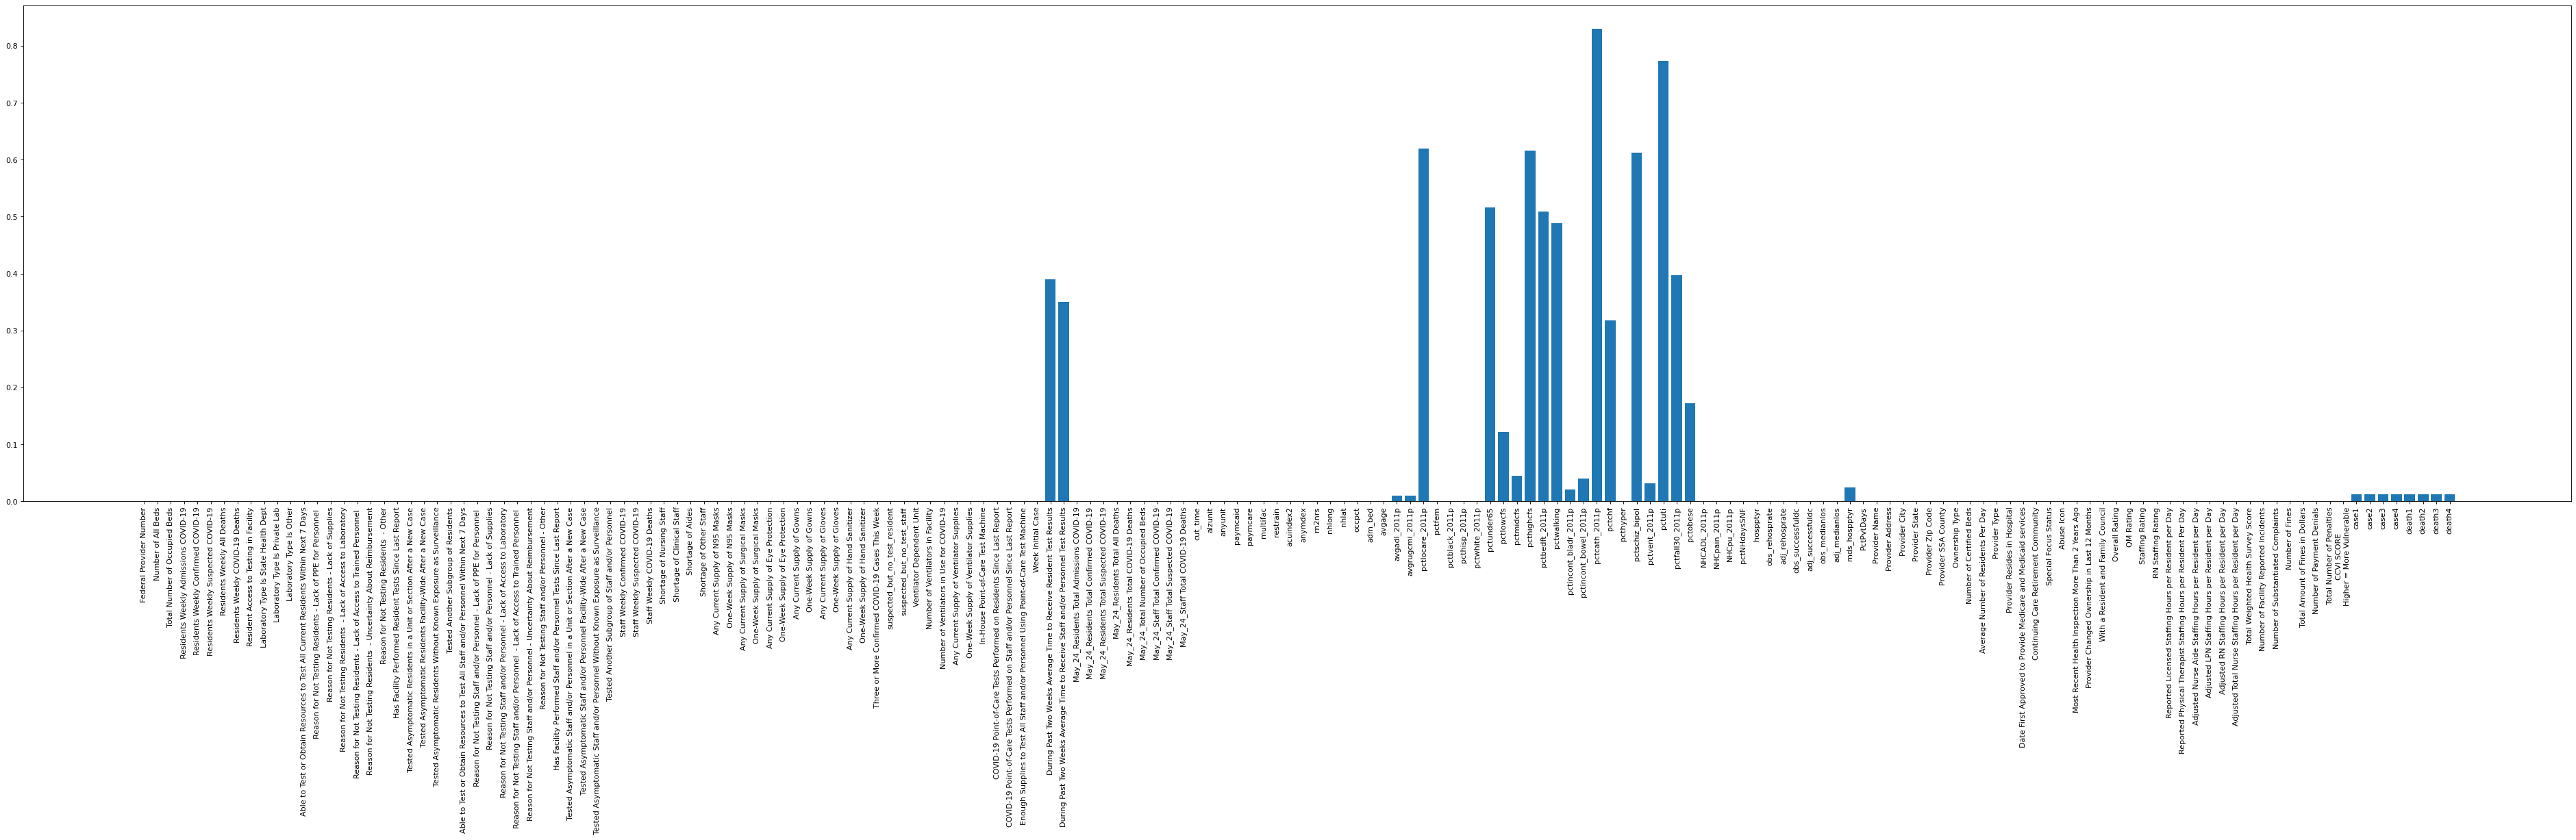

In [115]:
#Calculating the amount of missing datapoints within the features as a percentage of the features. 

def missing_pct_calculation(df_merge):
  '''
  calculate missing percantage for each variable
  '''
  pct_missing = []
  for col in df_merge.columns:
      pct_missing.append([col,np.mean(df_merge[col].isnull())])
  col_name = np.array([i[0] for i in pct_missing])
  col_pct =  np.array([i[1] for i in pct_missing])
 
  return col_name,col_pct
  
  
def bar_missing_value(col_name,col_pct):
  '''
  visualize the percentage as bar grapg
  '''
  plt.figure(num=None, figsize=(60, 12), dpi=80, facecolor='w', edgecolor='k')
  plt.bar(col_name,col_pct)
  plt.xticks(rotation=90)
  plt.show()



#percentage of missing variables in the merged data

name,pct = missing_pct_calculation(df)
bar_missing_value(name,pct)

In [116]:
ny_columns = [i for i in df.columns if re.search(r'(case|death)\d{1}',i)]

df[ny_columns] = df[ny_columns].fillna(0)


##Drop Features with Missing Data

In [117]:
df_keep = df.loc[:,df.isnull().sum() == 0]

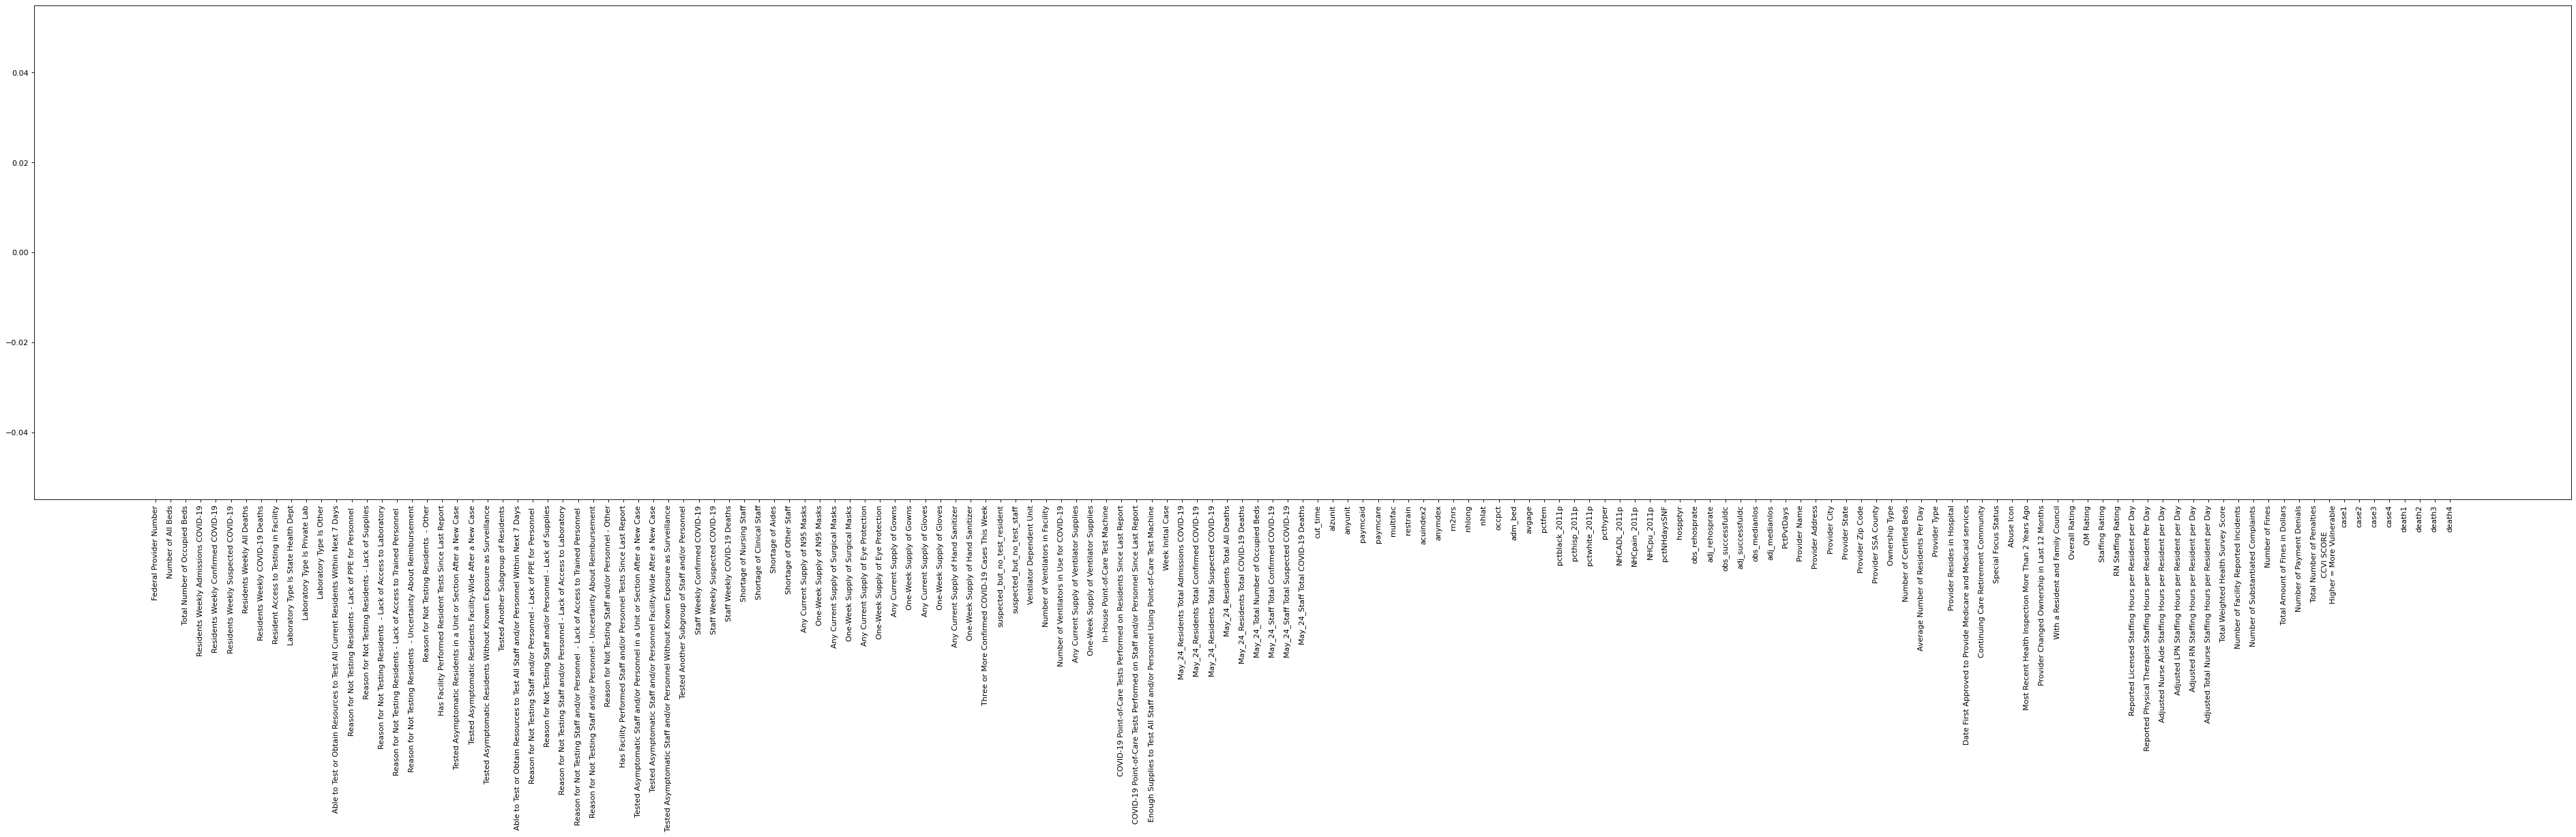

In [118]:
#Confirming number of features with missing datapoints is 0

name,pct = missing_pct_calculation(df_keep)
bar_missing_value(name,pct)

In [119]:
#creating another dataframe with the removed features from the analysis above

drop_list = ['paymcaid','paymcare','adm_bed','NHCpain_2011p','NHCpu_2011p','pctNHdaysSNF','hospptyr','obs_rehosprate',
   'obs_successfuldc', 'obs_medianlos', 'PctPvtDays',  'Provider Name',  'Provider Address', 'Date First Approved to Provide Medicare and Medicaid services'    ]
df_keep = df_keep.drop(columns = drop_list)

In [120]:
#Merging the inspection texts while removing the features from inspection texts that aren't needed

inspection = inspection.drop(["facility_name",'address','city','state','zip','total_YN','total_severity','total','Adiministration','Environmental','AbuseNeglect','NursingDietary','Nutrition',
                 'Pharmacy','QualityLife','CarePlanning','Rights'] ,axis=1)
df_keep = df_keep.merge(inspection, left_on="Federal Provider Number",right_on="facility_id",how="inner")
del df_keep['facility_id']

#Export Dataframe

In [ ]:
# df_keep
df_keep.to_csv('/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Final_Output/final_dataframe.csv', index=False)
aggregated_y.to_csv('/content/drive/My Drive/CapstoneProject/Final_folder/Skeleton/Final_Output/final_dataframe_label.csv')